### Данный ноутбук демонстрирует функциональную часть решения, посвященную совмещению процедуры A/B тестирования и поиска разладки на открытых данных из набора Open Bandit Pipeline

In [1]:
import pandas as pd
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm
import statsmodels.api as sm
from catboost import CatBoostClassifier, CatBoostRegressor
from catboost import Pool
import numpy as np
from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error

import time
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_coef_significance(X, Y): 
    """
    Функция для оценки статистической значимость коэффициентов линейной регрессии

    Параметры:
        X - DataFrame - данные, содержащие несколько объектов с признаками
        Y - array - целевая метрика для объектов из X

    Выход:
        table - DataFrame - таблица со значениями p-value, относительно которых можно делать вывод о статистической значимости коэффициента при каждом признаке в X.
        lin_reg - statsmodels.OLS - обученная модель регрессии
    """
    X_train = sm.tools.tools.add_constant(X.values.astype(np.float64), prepend=True, has_constant='skip')
    
    Y_train = Y

    lin_reg = sm.OLS(Y_train, X_train).fit()
    summary = lin_reg.summary().tables[1]
    table = pd.read_html(summary.as_html(), header=0, index_col=0)[0]
    return table, lin_reg

In [3]:
def check_pval(pval):
    """
    Функция для автоматической проверки p-value на статистическую значимость

    Параметры:
        pval - float - значение p-value
    """  
    if pval <= 0.05:
        print(f'p-val: {pval}\nСтат. значимая разница (отвергли нулевую гипотезу о равенстве средних)')
    else:
        print(f'p-val: {pval}\nСтатзначимой разницы нет')

In [4]:
def ttest(x, y, randomized=False, verbose=False):
    """
    Функция для проведения T-testa в двух модификациях: с обычной и с рандомизированной T-статистикой.

    Параметры:
        x - array - значение целевой метрики в тестовой группе
        y - array - значение целевой метрики в контрольной группе
        randomized - bool - индикатор того, какой тест проводить (рандомизированный - 1, стандартный - 0)
        verbose - bool - печатать ли вспомогательную информацию
        
    Выход:
         полученное в T-тесте p-value (float)
    """ 
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    s_x = np.var(x, ddof=1)
    s_y = np.var(y, ddof=1)
    
    if randomized:
        b0 = n_x ** 0.75
        b1 = n_y ** 0.75
        
        dof =  (s_x / n_x + s_y / n_y) ** 2 / ((s_x / n_x) ** 2 / (n_x - 1) + (s_y / n_y) ** 2 / (n_y - 1))
        
        
        theta_x = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b0)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_x // 4 + 1))
        
        theta_x = theta_x[:n_x]

        theta_y = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b1)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_y // 4 + 1))
        
        theta_y = theta_y[:n_y]

        t_val = (theta_x @ x - theta_y @ y) / np.sqrt(s_x * np.sum(theta_x ** 2) + s_y * np.sum(theta_y ** 2))
        p = 2*(stats.t.cdf(-abs(t_val), dof))
        
    else: 
        t_val, p = stats.ttest_ind(x, y, equal_var=False) 
        
    if verbose:
        check_pval(p)
    return p

In [5]:
def gumbel(x):
    """
    Функция, возвращающая квантиль порядка x распределения Гумбеля
    """
    return np.log(2 / np.log(1 / (1-x)))

Более подробное описание использованных в данном ноутбуке данных приведено в Секции 3 Отчета о втором этапе НИР. Считываем описания контекстов данных, собранных в формате .csv в соответствии с 2 разными политиками по сбору данных

In [8]:
#запустить данную ячейку 1 раз для распаковки данных
!unzip OBP_data.zip -d .

Archive:  OBP_data.zip
   creating: ./OBP_data/
  inflating: ./OBP_data/random_item_context.csv  
  inflating: ./__MACOSX/OBP_data/._random_item_context.csv  
  inflating: ./OBP_data/all_data.parquet  
  inflating: ./__MACOSX/OBP_data/._all_data.parquet  
  inflating: ./OBP_data/all_data_sorted.parquet  
  inflating: ./__MACOSX/OBP_data/._all_data_sorted.parquet  
  inflating: ./OBP_data/bts_item_context.csv  
  inflating: ./__MACOSX/OBP_data/._bts_item_context.csv  


In [9]:
bts_item = pd.read_csv("OBP_data/bts_item_context.csv", index_col=0)
random_item = pd.read_csv("OBP_data/random_item_context.csv", index_col=0)

In [10]:
for i in bts_item.columns[2:]:
    bts_item.loc[:, i] = pd.factorize(bts_item[i])[0]


for i in random_item.columns[2:]:
    random_item.loc[:, i] = pd.factorize(random_item[i])[0]

/var/folders/7k/bhy5k0c91n1fvpdds3f29rsr0000gq/T/ipykernel_40512/1258232884.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  bts_item.loc[:, i] = pd.factorize(bts_item[i])[0]
/var/folders/7k/bhy5k0c91n1fvpdds3f29rsr0000gq/T/ipykernel_40512/1258232884.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  random_item.loc[:, i] = pd.factorize(random_item[i])[0]


In [12]:
# Проверяем, что признаки баннеров в обоих датасетах совпадают
for i in random_item.columns[2:]:
    print((random_item.loc[:, i] == bts_item.loc[:, i]).all())

True
True
True


In [13]:
random_item.set_index('item_id', inplace=True)
bts_item.set_index('item_id', inplace=True)

user_features = ['user_feature_{}'.format(n) for n in range(4)]
user_hist = ['user-item_affinity_{}'.format(n) for n in range(80)]

In [14]:
#Считываем датасет с данными, относящимися к обеим политикам. На этапе считывания необходима библиотека fastparquet
all_data = pd.read_parquet("OBP_data/all_data.parquet")
all_data.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79,treatment
0,2019-11-24 00:00:00.047846+00:00,18,2,0,0.061300,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2019-11-24 00:00:00.049952+00:00,61,1,0,0.104925,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2019-11-24 00:00:00.052473+00:00,51,3,0,0.048620,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2019-11-24 00:00:00.503685+00:00,52,1,0,0.042980,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2019-11-24 00:00:00.505885+00:00,35,2,0,0.005890,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# A/B-test на всех данных

In [15]:
#формирование контрольной и тестовой групп
control = all_data[all_data['treatment'] == 0]
treatment = all_data[all_data['treatment'] == 1]

In [16]:
control['click'].mean()

0.0034693344451502445

In [17]:
treatment['click'].mean()

0.004953225649823585

In [18]:
#выполняем Т-тест
check_pval(ttest_ind(control['click'], treatment['click']).pvalue)

p-val: 7.047650951369447e-126
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


### Комбинируем разладку с подведением итога A/B теста

### МЕТОД CUSUM
**Описание в отчете:** секция 5.1, алгоритм 4

In [19]:
# Функция для вычисления тестовой статистики
#
# X -- массив наблюдений
#
# Возвращаемые значения:
# T -- одномерный массив значений тестовой статистики
#
def compute_cusum(X):
    
    T = np.zeros(X.shape[0])
    
    for n in range(1, X.shape[0]):
        
        t = np.zeros(n)
        
        # Шаг 2 алгоритма 4: вычисление выражения (5.5)
        for k in range(1, n):
            t[k] = abs((n - k) * X[:k].sum()   - k * X[k:n].sum() ) / np.sqrt(n * k * (n - k))
        
        # Шаг 3 алгоритма 4: вычисление тестовой статистики (5.6)
        T[n] = np.max(t)
    
    return T

In [20]:
#число интервалов разбиения датасета
num_chunks = 50

#рассматривем отдельно контрольную выборку
control_y = all_data[all_data['treatment'] == 0]['click']
control_y = np.asarray(control_y)

#список, в который будут добавляться средние значения тестовой статистики по наблюдаемым батчам данных
Y_mean_control = []

#рассматриваем схему с поступлением данных батчами равного размера
chunk_size = len(control_y) // num_chunks
print("размер батча данных = ",chunk_size)

#итерируем по датасету, подсчитываем среднее значение статистики по движущемуся окну, собираем все в массив
for ind in range(num_chunks):
    dat = control_y[ind*chunk_size:(ind+1)*chunk_size].mean()
    Y_mean_control.append(dat)

размер батча данных =  27486


Флуктуации выборочного среднего по батчам:

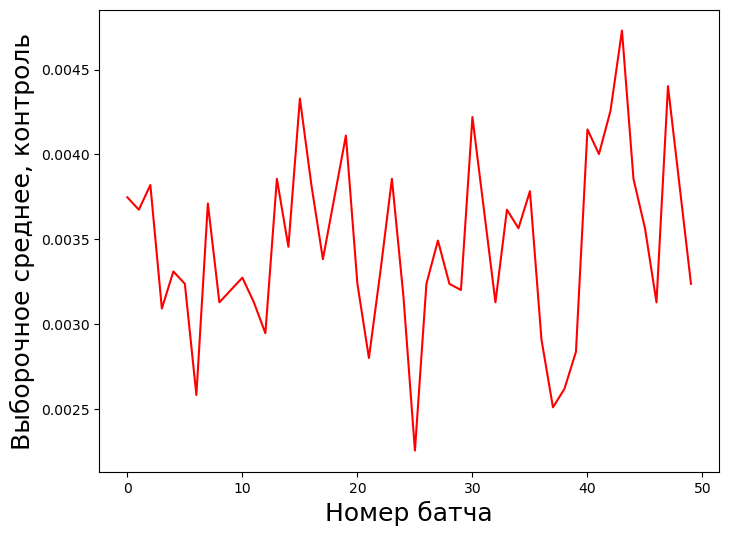

In [21]:
#построение графика
fig = plt.figure(figsize = (8,6))
plt.plot(np.arange(num_chunks),Y_mean_control, c = 'r')
plt.xlabel('Номер батча',fontsize=18)
plt.ylabel('Выборочное среднее, контроль',fontsize=18)
plt.show()

Аналогичные флуктуации для первых разностей выборочного среднего:

In [22]:
#инициализация массива первых разностей
Y_mean_diff_control = np.diff(Y_mean_control)

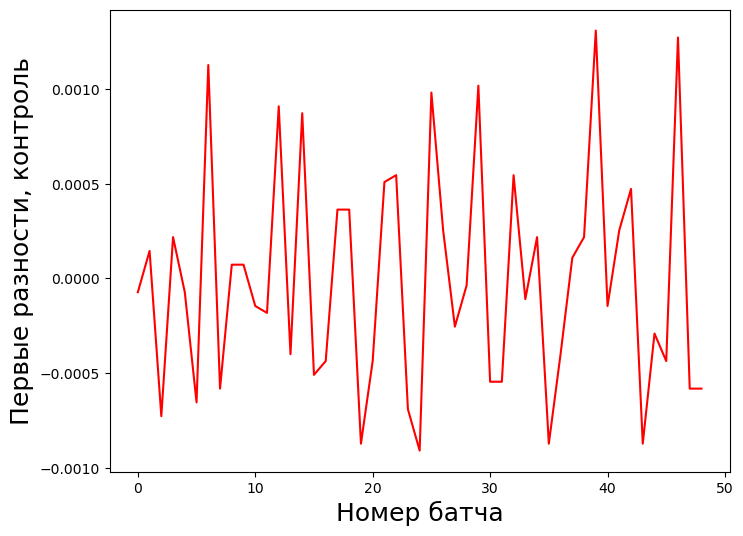

In [23]:
#построение графика
fig = plt.figure(figsize = (8,6))
plt.plot(np.arange(num_chunks-1),Y_mean_diff_control, c = 'r')
plt.xlabel('Номер батча',fontsize=18)
plt.ylabel('Первые разности, контроль',fontsize=18)
plt.show()

Предельным распределением тестовой статистики алгоритма CUSUM является распределение Гумбеля. Таким образом, можно рассчитать критическое значение данной статистики для заданного уровня значимости.

In [24]:
#квантиль распределения Гумбеля уровня 0.05
gumbel_quantile = gumbel(0.05)
#подсчет критического значения в соответствии с формулой () Отчета о 2-м этап НИР
c0 = 2*np.log(np.log(num_chunks)) + 0.5*np.log(np.log(np.log(num_chunks))) - 0.5*np.log(np.pi)

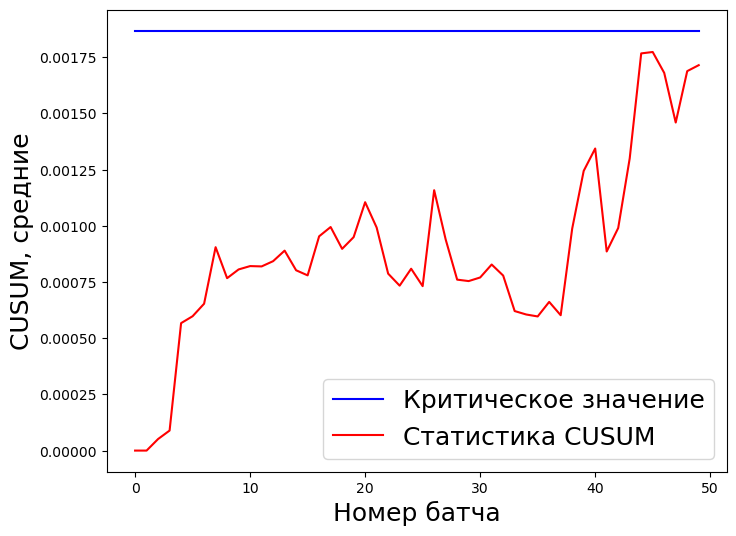

In [25]:
#подсчет статистики CUSUM
Cusum_stat = compute_cusum(np.asarray(Y_mean_control))
#вычисление критического значения для заданного массива
crit_value = np.asarray(Y_mean_control).std() * (gumbel_quantile + c0) / np.sqrt(2*np.log(np.log(num_chunks)))

#визуализация
fig = plt.figure(figsize = (8,6))
plt.plot(np.arange(num_chunks),crit_value*np.ones(num_chunks), c = 'b', label= 'Критическое значение')
plt.plot(np.arange(num_chunks),Cusum_stat, c = 'r', label= 'Статистика CUSUM')
plt.xlabel('Номер батча',fontsize=18)
plt.ylabel('CUSUM, средние',fontsize=18)
plt.legend(fontsize=18)
plt.show()

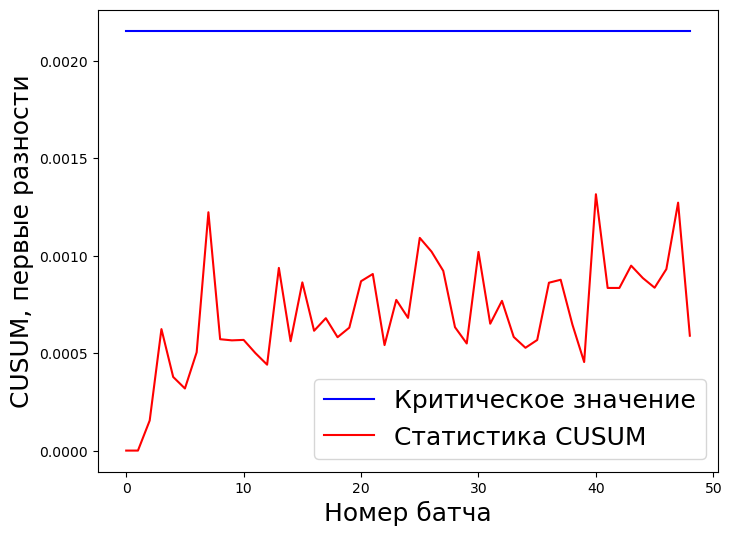

In [26]:
#аналогичные вычисления для первых разностей
#подсчет статистики CUSUM
Cusum_stat = compute_cusum(np.asarray(Y_mean_diff_control))
#вычисление критического значения для заданного массива
crit_value = np.asarray(Y_mean_diff_control).std() * (gumbel_quantile + c0) / np.sqrt(2*np.log(np.log(num_chunks)))

#визуализация
fig = plt.figure(figsize = (8,6))
plt.plot(np.arange(num_chunks-1),crit_value*np.ones(num_chunks-1), c = 'b', label = 'Критическое значение')
plt.plot(np.arange(num_chunks-1),Cusum_stat, c = 'r', label= 'Статистика CUSUM')
plt.xlabel('Номер батча',fontsize=18)
plt.ylabel('CUSUM, первые разности',fontsize=18)
plt.legend(fontsize=18)
plt.show()

Таким образом, можно утверждать, что разладка при формировании контрольной группы наблюдений не обнаружена. Повторим теперь эту же процедуру для тестовой группы.

In [27]:
#число интервалов разбиения датасета
num_chunks = 50

#рассматривем отдельно контрольную выборку
treatment_y = all_data[all_data['treatment'] == 1]['click']
treatment_y = np.asarray(treatment_y)

Y_mean_treatment = []


chunk_size = len(treatment_y) // num_chunks
print("размер батча данных = ",chunk_size)

#итерируем по датасету, подсчитываем среднее значение статистики по движущемуся окну, собираем все в массив
for ind in range(num_chunks):
    dat = treatment_y[ind*chunk_size:(ind+1)*chunk_size].mean()
    Y_mean_treatment.append(dat)

размер батча данных =  247144


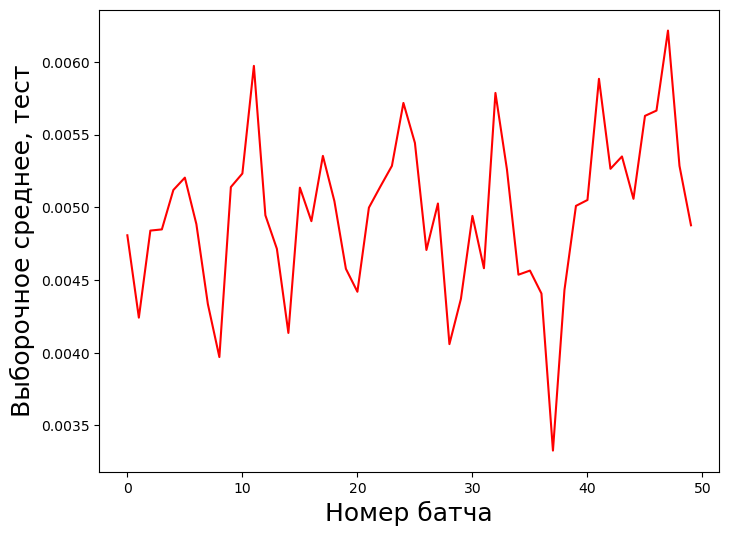

In [28]:
#построение графика
fig = plt.figure(figsize = (8,6))
plt.plot(np.arange(num_chunks),Y_mean_treatment, c = 'r')
plt.xlabel('Номер батча',fontsize=18)
plt.ylabel('Выборочное среднее, тест',fontsize=18)
plt.show()

In [29]:
#инициализация массива первых разностей
Y_mean_diff_treatment = np.diff(Y_mean_treatment)

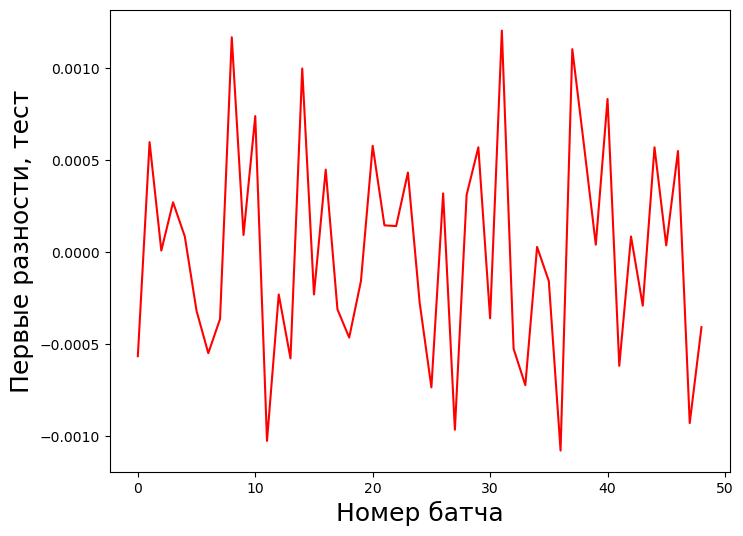

In [30]:
#построение графика
fig = plt.figure(figsize = (8,6))
plt.plot(np.arange(num_chunks-1),Y_mean_diff_treatment, c = 'r')
plt.xlabel('Номер батча',fontsize=18)
plt.ylabel('Первые разности, тест',fontsize=18)
plt.show()

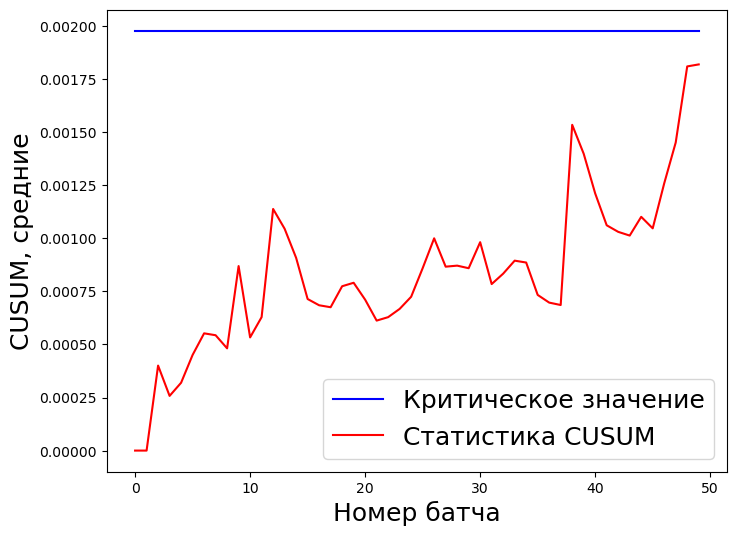

In [31]:
#подсчет статистики CUSUM
Cusum_stat = compute_cusum(np.asarray(Y_mean_treatment))
#вычисление критического значения для заданного массива
crit_value = np.asarray(Y_mean_treatment).std() * (gumbel_quantile + c0) / np.sqrt(2*np.log(np.log(num_chunks)))

#визуализация
fig = plt.figure(figsize = (8,6))
plt.plot(np.arange(num_chunks),crit_value*np.ones(num_chunks), c = 'b', label = 'Критическое значение')
plt.plot(np.arange(num_chunks),Cusum_stat, c = 'r', label= 'Статистика CUSUM')
plt.xlabel('Номер батча',fontsize=18)
plt.ylabel('CUSUM, средние',fontsize=18)
plt.legend(fontsize=18)
plt.show()

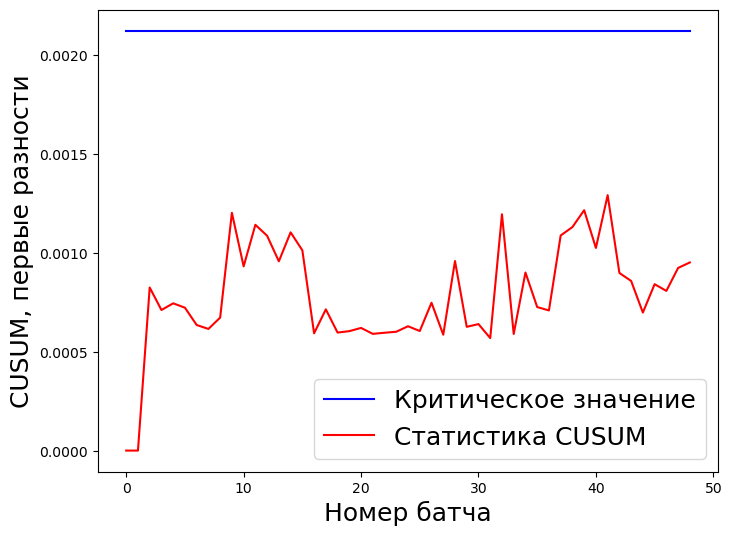

In [32]:
#аналогичные вычисления для первых разностей
#подсчет статистики CUSUM
Cusum_stat = compute_cusum(np.asarray(Y_mean_diff_treatment))
#вычисление критического значения для заданного массива
crit_value = np.asarray(Y_mean_diff_treatment).std() * (gumbel_quantile + c0) / np.sqrt(2*np.log(np.log(num_chunks)))

#визуализация
fig = plt.figure(figsize = (8,6))
plt.plot(np.arange(num_chunks-1),crit_value*np.ones(num_chunks-1), c = 'b', label = 'Критическое значение')
plt.plot(np.arange(num_chunks-1),Cusum_stat, c = 'r', label= 'Статистика CUSUM')
plt.xlabel('Номер батча',fontsize=18)
plt.ylabel('CUSUM, первые разности',fontsize=18)
plt.legend(fontsize=18)
plt.show()

### Проверка возможностей алгоритмов снижения дисперсии для ускорения поиска разладки и повышения их чувствительности.

### Код методов снижения дисперсии

In [33]:
def modify_with_cuped(control, experimental, columns, model, verbose=False):
    y_c = control['click']
    y_e = experimental['click']
    
    c = control[columns]
    e = experimental[columns]
    
    # Изменение целевой переменной
    control_cuped = y_c - model.predict(c)  + model.predict(c).mean()
    experimental_cuped = y_e - model.predict(e) + model.predict(e).mean()

    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}\n")
    
    p_before = ttest(y_c, y_e)
    
    p_after = ttest(control_cuped, experimental_cuped)
    return p_before, p_after

In [34]:
def modify_with_cupac(control, experimental, columns, model, verbose=False):
    y_c = control['click']
    y_e = experimental['click']
    
    c = control[columns]
    e = experimental[columns]
    
    # Изменение целевой переменной
    control_cupac = y_c - model.predict(c)  + model.predict(c).mean()
    experimental_cupac = y_e - model.predict(e) + model.predict(e).mean()

    if verbose:
        print(f"control var new: {np.var(control_cupac)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cupac)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cupac.mean() - experimental_cupac.mean()}\n")
    
    
    p_before = ttest(y_c, y_e)
    
    p_after = ttest(control_cupac, experimental_cupac)
    return p_before, p_after

In [35]:
def modify_with_ml_rate(control, experimental, history, columns, verbose=False, aa=False):
    """
    Применение метода Ml-rate к контрольной и тестовой выборкам

    Параметры:
        control - DataFrame - объекты, относящиеся к контрольной группе
        experimental - DataFrame - объекты, относящиеся к контрольной группе
        history - DataFrame - объекты, относящиеся к историческим данным
        columns - list[str] - имена признаков, используемые в качестве контрольных переменных
        verbose - bool - печатать ли впомогательную информацию 
        aa - bool - проводится ли AA тест
    Выход:
        p-value - float - значение p-value до и после применения Ml-rate
    """
    if verbose:
        print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")
    
    if aa:
        experimental['treatment'] = 1
        
    Z = pd.concat((control, experimental, history), axis=0).sample(frac=1)
    
    Y = Z['click']
    X = Z[columns]
    
    X = pd.concat((X, Z['treatment'].reset_index()), ignore_index=True, axis=1)
    
    # Обучение модели линейной регрессии
    table_summary, model = get_coef_significance(X, Y)
    pval = table_summary.iloc[-1, :]['P>|t|']
    
    return pval

In [36]:
def fit_catboost(data, numerical_columns, categorical_columns=[], val=None):
    """
    Функция для регрессии целевой переменной на основе градиентного бустинга (catboost)
    """
    columns = numerical_columns + categorical_columns
    if isinstance(data, pd.DataFrame):
        X = data[columns]
        Y = data['click']
    else:
        X, Y = data
        X = X[columns]

    cb_regressor = CatBoostRegressor(iterations=100)
    cb_regressor.fit(X[columns], Y,
                    cat_features=categorical_columns,
                    eval_set=val,
                    verbose=True
                    )
    return cb_regressor

In [37]:
def fit_regression(data, numerical_columns, categorical_columns, pipeline=False):
    columns = numerical_columns + categorical_columns
    if isinstance(data, pd.DataFrame):
        X = data[columns]
        Y = data['click']
    else:
        X, Y = data
        X = X[columns]
    print(X.shape)
    print(Y.shape)

    if pipeline:
        categorical_encoder = OneHotEncoder(
        handle_unknown="error",
        drop='first'
        )

        numerical_encoder = SimpleImputer(strategy="mean")

        preprocessing = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_columns),
                ("num", numerical_encoder, numerical_columns),
            ],
            #verbose_feature_names_out=False,
        )

        linear_regressor = Pipeline(
            [
                ("preprocess", preprocessing),
                ("regressor", linear_model.LinearRegression()),
            ]
        )
    else:
        linear_regressor = Pipeline(
            [
                ("regressor", model_type),
            ]
        ) 
        X = X[numerical_columns + categorical_columns]
        

    linear_regressor.fit(X, Y)
    return linear_regressor

## Отбор исторической выборки и обучение моделей

In [38]:
all_data_sorted = pd.read_parquet("OBP_data/all_data_sorted.parquet")
all_data_sorted.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79,treatment
1801291,2019-11-24 22:30:27.608352+00:00,61,2,0,0.094270,1,1,4,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1801290,2019-11-24 22:30:27.608352+00:00,7,1,0,0.076565,1,1,4,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1801292,2019-11-24 22:30:27.609360+00:00,69,3,0,0.034665,1,1,4,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1801293,2019-11-24 22:30:27.825328+00:00,38,1,0,0.029000,2,2,2,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1801294,2019-11-24 22:30:27.825670+00:00,7,3,0,0.142150,2,2,2,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [39]:
#установка временной отсечки
threshold_time = all_data_sorted[:int(all_data_sorted.shape[0] * 0.8)].timestamp.iloc[-1]
threshold_time

Timestamp('2019-11-29 13:55:05.096141+0000', tz='UTC')

In [40]:
#предыстория для обучения регрессии
history = all_data_sorted[((all_data_sorted['timestamp'] <= threshold_time))]
history.shape

(9385221, 90)

In [41]:
#тестовые данные - последние 20% датасета в соответствии с временной отсечкой
data = all_data_sorted[all_data_sorted['timestamp'] > threshold_time]
data.shape
#разделение данного набора на контрольную и экспериментальную части
all_control = data[data['treatment'] == 0]
all_experimental = data[data['treatment'] == 1]

In [42]:
#исторические признаки и история целевой переменной
X = history
Y = X['click']

item_column = "user-item_affinity_" + X['item_id'].astype(str)
item_features = random_item.loc[X['item_id'].values].reset_index().drop(columns=['item_id'])

#генерация нового признака - история кликов
X['user_hist'] = X[user_hist].sum(axis=1)
X = pd.concat((X.reset_index(), item_features), axis=1)
X.head()

/var/folders/7k/bhy5k0c91n1fvpdds3f29rsr0000gq/T/ipykernel_40512/3250143234.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['user_hist'] = X[user_hist].sum(axis=1)


,index,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,...,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79,treatment,user_hist,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,1801291,2019-11-24 22:30:27.608352+00:00,61,2,0,0.094270,1,1,4,1,...,0.0,0.0,0.0,0.0,1,0.0,-0.276153,0,0,0
1,1801290,2019-11-24 22:30:27.608352+00:00,7,1,0,0.076565,1,1,4,1,...,0.0,0.0,0.0,0.0,1,0.0,-0.276153,4,0,0
2,1801292,2019-11-24 22:30:27.609360+00:00,69,3,0,0.034665,1,1,4,1,...,0.0,0.0,0.0,0.0,1,0.0,-0.677587,5,14,2
3,1801293,2019-11-24 22:30:27.825328+00:00,38,1,0,0.029000,2,2,2,2,...,0.0,0.0,0.0,0.0,1,0.0,2.689996,2,8,1
4,1801294,2019-11-24 22:30:27.825670+00:00,7,3,0,0.142150,2,2,2,2,...,0.0,0.0,0.0,0.0,1,0.0,-0.276153,4,0,0


In [43]:
#Делим обучающую выборку на валидационную и тестовую части для првоерки качества моделей
total_shape = X.shape[0]
#размер валидации
val_shape = int(total_shape * 0.1)
#размер теста
test_shape = int(total_shape * 0.1)
#размер обучающей подвыборки для модели
train_shape = total_shape - test_shape - val_shape
#выделение датасетов
X_train = X.iloc[:train_shape]
Y_train = Y.iloc[:train_shape]
X_val = X.iloc[train_shape: train_shape + val_shape]
Y_val = Y.iloc[train_shape: train_shape + val_shape]
X_test = X.iloc[train_shape + val_shape:]
Y_test = Y.iloc[train_shape + val_shape:]

print(f"Train: {Y_train.shape}, Val: {Y_val.shape}, Test: {Y_test.shape}")

#выделение числовых и категориальных признаков
numerical_columns = ['user_hist'] + ['item_feature_0']
categorical_columns = user_features + ['item_feature_1', 'item_feature_2', 'item_feature_3']
cols = numerical_columns + categorical_columns
cols

#центрирование числовых признаков
means = X_train[numerical_columns].mean()
X_train[numerical_columns] = X_train[numerical_columns] - means
X_val[numerical_columns] = X_val[numerical_columns] - means

Train: (7508177,), Val: (938522,), Test: (938522,)


/var/folders/7k/bhy5k0c91n1fvpdds3f29rsr0000gq/T/ipykernel_40512/2765049446.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_columns] = X_train[numerical_columns] - means
/var/folders/7k/bhy5k0c91n1fvpdds3f29rsr0000gq/T/ipykernel_40512/2765049446.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[numerical_columns] = X_val[numerical_columns] - means


In [44]:
#обучение моделей
#обучение линейной модели для метода CUPED
linear_regressor = fit_regression(X_train, numerical_columns,  categorical_columns, pipeline=True)

#обучение бустинга для CUPAC
cb_regressor = fit_catboost(X_train, numerical_columns, categorical_columns, val=(X_val[numerical_columns + categorical_columns], X_val['click']))

(7508177, 9)
(7508177,)
Learning rate set to 0.5
0:	learn: 0.0689709	test: 0.0636557	best: 0.0636557 (0)	total: 1.27s	remaining: 2m 6s
1:	learn: 0.0689648	test: 0.0636529	best: 0.0636529 (1)	total: 2.17s	remaining: 1m 46s
2:	learn: 0.0689599	test: 0.0636507	best: 0.0636507 (2)	total: 3.15s	remaining: 1m 41s
3:	learn: 0.0689572	test: 0.0636511	best: 0.0636507 (2)	total: 4.21s	remaining: 1m 41s
4:	learn: 0.0689561	test: 0.0636514	best: 0.0636507 (2)	total: 4.99s	remaining: 1m 34s
5:	learn: 0.0689539	test: 0.0636499	best: 0.0636499 (5)	total: 5.75s	remaining: 1m 30s
6:	learn: 0.0689523	test: 0.0636501	best: 0.0636499 (5)	total: 6.48s	remaining: 1m 26s
7:	learn: 0.0689469	test: 0.0636505	best: 0.0636499 (5)	total: 7.41s	remaining: 1m 25s
8:	learn: 0.0689456	test: 0.0636512	best: 0.0636499 (5)	total: 8.3s	remaining: 1m 23s
9:	learn: 0.0689426	test: 0.0636489	best: 0.0636489 (9)	total: 8.88s	remaining: 1m 19s
10:	learn: 0.0689410	test: 0.0636485	best: 0.0636485 (10)	total: 9.57s	remaining: 1

93:	learn: 0.0689045	test: 0.0636560	best: 0.0636479 (18)	total: 1m 10s	remaining: 4.51s
94:	learn: 0.0689042	test: 0.0636563	best: 0.0636479 (18)	total: 1m 11s	remaining: 3.76s
95:	learn: 0.0689038	test: 0.0636567	best: 0.0636479 (18)	total: 1m 11s	remaining: 3s
96:	learn: 0.0689033	test: 0.0636560	best: 0.0636479 (18)	total: 1m 12s	remaining: 2.25s
97:	learn: 0.0689033	test: 0.0636561	best: 0.0636479 (18)	total: 1m 13s	remaining: 1.5s
98:	learn: 0.0689033	test: 0.0636561	best: 0.0636479 (18)	total: 1m 14s	remaining: 749ms
99:	learn: 0.0689030	test: 0.0636562	best: 0.0636479 (18)	total: 1m 14s	remaining: 0us

bestTest = 0.06364788815
bestIteration = 18

Shrink model to first 19 iterations.


### Применение методов CUPED и CUPAC на подмножествах валидационной выборки разного размера

In [45]:
shape = 300_000 #попробовать разные от 100_000 до 900_000
data_part = X_val[:shape]

X  = data_part
control_ = X[X['treatment'] == 0]
experimental_ = X[X['treatment'] == 1]


p_before_1, p_after_1 = modify_with_cuped(control_, experimental_, cols, linear_regressor, verbose=True)
p_before_2, p_after_2 = modify_with_cupac(control_, experimental_, cols, cb_regressor, verbose=True)
print(f"CUPED: Before: {p_before_1}, After: {p_after_1}")
print(f"CUPAC: Before: {p_before_2}, After: {p_after_2}")

control var new: 0.0042797791027589386, var old: 0.004276799631823716
exper var new: 0.004581499492416526, var old: 0.004583334566236951
Mean diff
old: -0.00030928752694176463, new: -0.00030928752694176463

control var new: 0.00427185219861195, var old: 0.004276799631823716
exper var new: 0.004580802489012014, var old: 0.004583334566236951
Mean diff
old: -0.00030928752694176463, new: -0.00030928752694176463

CUPED: Before: 0.4369570854272057, After: 0.43708975311652265
CUPAC: Before: 0.4369570854272057, After: 0.43670659686223956


### Применение метода ML-RATE на подмножествах валидационной выборки разного размера

In [46]:
shape = 300_000 #попробовать разные от 100_000 до 900_000
data_part = X_val[:shape]

X  = data_part
X[numerical_columns] = X[numerical_columns] - X[numerical_columns].mean()

control_ = X[X['treatment'] == 0]
experimental_ = X[X['treatment'] == 1]

p_val_mlrate = modify_with_ml_rate(control_, experimental_, X_train,  columns = numerical_columns, verbose=False, aa=False)
print(p_val_mlrate)

/var/folders/7k/bhy5k0c91n1fvpdds3f29rsr0000gq/T/ipykernel_40512/1954498873.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_columns] = X[numerical_columns] - X[numerical_columns].mean()


0.588


Видно, что ассоциированное с данными методами снижение дисперсии целевой метрики незначительно (менее 1\%). Таким образом, нет оснований полагать, что данные методы скажутся на чувствительности алгоритмов поиска разладки